 # The Role of Non-Profits in Public Health Service Provision
 
 ## By Charles Rahal and John Mohan
 
 #### Last Updated: 30/08/2020

The role and extent of external suppliers across statutory health insurance procurement processes varies widely and is a source of political contention throughout the modern world. We comprehensively examine the role of the Third Sector in public health procurement within publicly funded healthcare which runs parallel to private provision in a 'two-tier' system. We build a unique ‘Big Data’ based methodological pipeline which scrapes tens of thousands of heterogeneous accounting datasets from across the commissioning pipeline; from centralised commissioning (in the form of NHS England), decentralised Clinical Commissioning Groups, and various types of NHS Trusts. These datasets provide granular information on every element of procurement at the micro-level (where the value of a transaction is greater than twenty-five thousand pounds), mandated by transparency requirements introduced by David Cameron in 2012. We develop data scientific tools to parse these datasets and reconcile suppliers with institutional registers, with a focus on non-profits registered on the Charity Commission for England and Wales (CCEW). The processed dataset contains over four hundred and forty-five billion pounds worth of commissioning across over 1.9 million rows of clean data. Our substantive findings are multiple. We estimate that almost 1% at each level of the procurement heirarchy comes from institutions listed on the CCEW: a number relatively consistent across time, despite annual contractual patterns coinciding with the financial year. We show huge only a slight regional variation and analyze the 'North-South' divide. Linking to the International Classification of Non-profit Organizations (ICNPO) and undertaking natural language processing on charity objectives, we show a ranged involvement of multiple different types of charity classification, with more payments going to the ‘Social Services’ aggregate, but the highest cumulative values of payments going to the 'Health' aggregate. We analyse the distribution of contracts to charities across various sizes and ages, from grassroots to ‘Super Major’ non-profits. We conclude with a discussion of the sector more generally in relation to the effects of the controversial Health and Social Care Act of 2012.

### 1.1 Lets load some dependancies

Load in all of the libraries (`pip install requirements.txt` in '..') and custom functions specifically created for this project which are found in `analysis\general_analysis_functions.py` and `analysis\charity_analysis_functions.py`.

In [1]:
import os
import pandas as pd
from helper_functions import hide_toggle
from general_analysis_functions import (load_suppliers,
                                        load_payments,
                                        scoring_figures,
                                        summarize_payments,
                                        plot_match_distribution,
                                        summarize_payments,
                                        plot_macro_overview,
                                        analyze_registers,
                                        calc_total_files,
                                        make_table_one,
                                        normalizer,
                                        overlapping_summary,
                                        check_payments,
                                        make_dfs_for_coauthors,
                                        check_payments_abs)
from charity_analysis_functions import (tabulate_charities,
                                        icnpo_groupings,
                                        load_ccname,
                                        make_inc_table,
                                        load_ccfin,
                                        make_rolling_windows,
                                        load_ccclass,
                                        something_with_nuts1,
                                        plot_temporal_makemonths,
                                        load_icpno,
                                        cyclical_3200,
                                        build_charity_df,
                                        make_gdf,
                                        make_income_dists,
                                        make_ccg_to_gdf,
                                        plot_choropleths_ccg,
                                        plot_choropleths_trusts,
                                        plot_heatmaps,
                                        make_monthly,
                                        make_annual,
                                        charity_age,
                                        more_or_less_by_age,
                                        class_groupings,
                                        make_temporal_df,
                                        make_rolling_windows_top10,
                                        plot_temporal,
                                        plot_conc,
                                        make_obj_freq)
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:63% !important; }</style>"))
display(HTML("<style>.output_result { max-width:63% !important; }</style>"))
hide_toggle()

### 1.2 Set paths

Lets now set all of the paths we're going to need later on in the notebook.

In [2]:
data_path = os.path.abspath(os.path.join(os.getcwd(), '../..', 'data'))
cc_path = os.path.join(data_path, 'data_cc')
ch_path = os.path.join(data_path, 'data_ch')
nhsdigital_path = os.path.join(data_path, 'data_nhsdigital')
master_path = os.path.join(data_path, 'data_masteringest')
merge_path = os.path.join(data_path, 'data_merge')
recon_path = os.path.join(data_path, 'data_reconciled')
norm_path = os.path.join(data_path, 'data_support', 'norm_dict.tsv')
support_path = os.path.join(data_path, 'data_support')
shape_path = os.path.join(data_path, 'data_shapefiles')
figure_path = os.path.abspath(os.path.join(
                              os.path.join(os.getcwd(),
                                           '../..', 'papers', 'figures')))
table_path = os.path.abspath(os.path.join(
                             os.path.join(os.getcwd(),
                                          '../..', 'papers', 'tables')))
hide_toggle()

### 1.2 Load key datasets

Lets now load the hard earned datasets from all the data creation pipeline.

In [3]:
sup_df = load_suppliers(os.path.join(recon_path, 'recon_verified.tsv'))
ccg_pay_df = load_payments(os.path.join(merge_path, 'ccg_merged_with_recon.tsv'))
trust_pay_df = load_payments(os.path.join(merge_path, 'trust_merged_with_recon.tsv'))
nhsengland_pay_df = load_payments(os.path.join(merge_path, 'nhsengland_merged_with_recon.tsv'))
cc_name = load_ccname(cc_path, norm_path)
cc_objects = pd.read_csv(os.path.join(cc_path, 'extract_objects.csv'),
                         error_bad_lines=False, warn_bad_lines=False,
                         encoding='utf-8', engine='c', lineterminator='\n')
icnpo_df, icnpo_lookup = load_icpno(support_path)
cc_fin = load_ccfin(cc_path)
cc_class = load_ccclass(cc_path)
hide_toggle()

The percent of charities without an address:  0.45474137344591414
The percent of unique regnos in our database:  327547


### 1.2.1. Make dataset for coauthors

In [4]:
make_dfs_for_coauthors(ccg_pay_df, trust_pay_df, nhsengland_pay_df,
                       cc_name, merge_path, ch_path, data_path)

### 1.3 Plot a general overview of some national accounting data

See the figure note in the paper for more details on exactly which data comes from where!

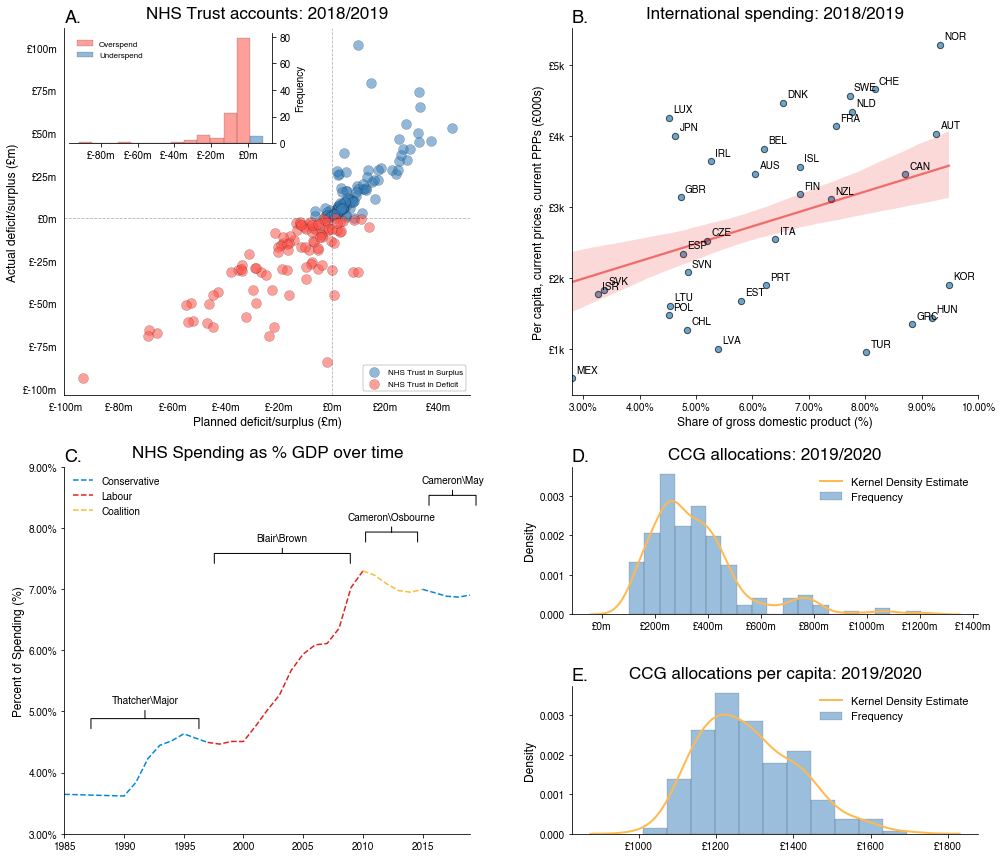

In [5]:
plot_macro_overview(data_path, figure_path)

## 2. Check and summarize the raw payments dataset

### 2.1 How many institutions were there at the time of the last scrape?

In [6]:
print('There are 221 Trusts in our meta list.')
print('There are 191 Trusts in our meta list.')
hide_toggle()

There are 221 Trusts in our meta list.
There are 191 Trusts in our meta list.


### 2.2 How many files did we get?

In [7]:
ccg_rawpath = os.path.join(data_path, 'data_nhsccgs', 'raw')
trust_rawpath = os.path.join(data_path, 'data_nhstrusts', 'raw')
ccg_files = calc_total_files(ccg_rawpath)[0]
ccg_folders = calc_total_files(ccg_rawpath)[1]
print('CCG folders: ' +  str(ccg_folders))
print('CCG files: ' +  str(ccg_files))
trust_files = calc_total_files(trust_rawpath)[0]
trust_folders = calc_total_files(trust_rawpath)[1]
print('Trust folders: ' +  str(trust_folders))
print('Trust files: ' +  str(trust_files))
hide_toggle()

CCG folders: 192
CCG files: 12709
Trust folders: 216
Trust files: 12561


### 2.3 Check the raw payments here

Write a function which verifies our manual check of the 50 largest payments of each dataset (i.e. for bad potentially serious bad parses)

In [8]:
check_payments(ccg_pay_df,
               os.path.join(data_path,'data_support',
                            'filechecker_ccg.csv'), data_path, 'ccg', 50)
check_payments(trust_pay_df,
               os.path.join(data_path,'data_support',
                            'filechecker_trust.csv'), data_path, 'trust', 50)
hide_toggle()

Cool! No more ccg payments to check by order...
Cool! No more ccg payments to check by groupby...
Cool! No more trust payments to check by order...
Cool! No more trust payments to check by groupby...


And then for absolute amounts:

In [9]:
check_payments_abs(ccg_pay_df,
                   os.path.join(data_path,'data_support',
                                          'abs_filechecker_ccg.csv'), data_path, 'ccg', 50)
check_payments_abs(trust_pay_df,
                   os.path.join(data_path,'data_support',
                                          'abs_filechecker_trust.csv'), data_path, 'trust', 50)
hide_toggle()

Cool! No more ccg absolute amount payments to check by order...
Cool! No more ccg absolute amount payments to check by groupby...
Cool! No more trust absolute amount payments to check by order...
Cool! No more trust absolute amount payments to check by groupby...


### 2.4 Analyze institutional registers

Lets quickly check just how unique the actual institutions going into our match are!

In [10]:
analyze_registers(ch_path, cc_path, nhsdigital_path, master_path)
hide_toggle()

Number unique raw CH entries: 4490685
Number non-duplicated normalized CH entries: 4489992
Number unique raw CC entries: 469691
Number non-duplicated normalized CC entries: 463733
Number unique raw NHS Digital entries: 45739
Number non-duplicated normalized NHS Digital entries: 45560
Number unique raw combined entries: 4851121
Number non-duplicated normalized combined entries: 4873882
There are 51575 normalised unique names on both CH and CC
There are 1408 normalised unique names on both CH and NHS
There are 1280 normalised unique names on both CC and NHS
There are 371 normalised unique names on all 3


### 2.5 Summarize the results of our data curation proceedure

Lets first summarize the payments from just CCGs:

In [11]:
summarize_payments(ccg_pay_df, 'CCG')
hide_toggle()

Describing cleaned CCG payments dataset!
Length of dataset: 647541
Total unique raw suppliers: 15830
Total unique verified suppliers: 7873
Total value (£) of dataset: 204135969000
Smallest value payment: -30100000
Biggest value payment: 58249359
Average value payment: 315247
Earliest payment was: 2010-12-24 00:00:00
Latest payment was: 2020-02-29 00:00:00
Most payments is:  NHS_LEE_CCG (20202)
Highest value payments is: NHS_LEE_CCG (£6099739105)
Most payments (other than "no match"): BMI HEALTHCARE LIMITED (6824)
Highest value of payments (other than "no match") is: SHEFFIELD TEACHING HOSPITALS NHS FOUNDATION TRUST (3257659088.0)
Number of organisations in clean dataset is: 173
Number of files in clean dataset is: 7747


and for NHS England:

In [12]:
summarize_payments(nhsengland_pay_df, 'NHS England')
hide_toggle()

Describing cleaned NHS England payments dataset!
Length of dataset: 602348
Total unique raw suppliers: 11979
Total unique verified suppliers: 5686
Total value (£) of dataset: 154847996123
Smallest value payment: -50000000
Biggest value payment: 340434000
Average value payment: 257073
Earliest payment was: 2013-04-24 00:00:00
Latest payment was: 2019-09-30 00:00:00
Most payments is:  NHS_England (602348)
Highest value payments is: NHS_England (£154847996123)
Most payments (other than "no match"): SPECSAVERS UK LIMITED (10857)
Highest value of payments (other than "no match") is: GUYS AND ST THOMAS NHS FOUNDATION TRUST (3387936729.0)
Number of organisations in clean dataset is: 1
Number of files in clean dataset is: 68


and then for just NHS Trusts...

In [13]:
summarize_payments(trust_pay_df, 'Trust')
hide_toggle()

Describing cleaned Trust payments dataset!
Length of dataset: 663591
Total unique raw suppliers: 24495
Total unique verified suppliers: 11202
Total value (£) of dataset: 87651739474
Smallest value payment: -108619414
Biggest value payment: 139956473
Average value payment: 132086
Earliest payment was: 2010-01-04 00:00:00
Latest payment was: 2020-03-31 00:00:00
Most payments is:  NHS_GUY_Trust (27064)
Highest value payments is: NHS_IMP_Trust (£3980463759)
Most payments (other than "no match"): NHS SUPPLY CHAIN (36196)
Highest value of payments (other than "no match") is: HM REVENUE AND CUSTOMS (9157152433.84)
Number of organisations in clean dataset is: 189
Number of files in clean dataset is: 8587


And then for a merged dataframe of both CCGs and NHS Trusts:

In [14]:
summarize_payments(pd.concat([nhsengland_pay_df, trust_pay_df, ccg_pay_df],
                             ignore_index=True), 'Combined')
hide_toggle()

Describing cleaned Combined payments dataset!
Length of dataset: 1913480
Total unique raw suppliers: 42998
Total unique verified suppliers: 19060
Total value (£) of dataset: 446635704597
Smallest value payment: -108619414
Biggest value payment: 340434000
Average value payment: 233415
Earliest payment was: 2010-01-04 00:00:00
Latest payment was: 2020-03-31 00:00:00
Most payments is:  NHS_England (602348)
Highest value payments is: NHS_England (£154847996123)
Most payments (other than "no match"): NHS SUPPLY CHAIN (36950)
Highest value of payments (other than "no match") is: HM REVENUE AND CUSTOMS (9570329945.84)
Number of organisations in clean dataset is: 363
Number of files in clean dataset is: 16311


### 2.6 Make Table One

And then wrangle this data into what goes into Table One in the accompanying paper:

In [15]:
make_table_one(ccg_pay_df, trust_pay_df, nhsengland_pay_df, table_path)
hide_toggle()

## 3 Visualise the approximate matches

Lets see how our matching algorithms perform by plotting Elastic Search match scores against Levenhstein ones.

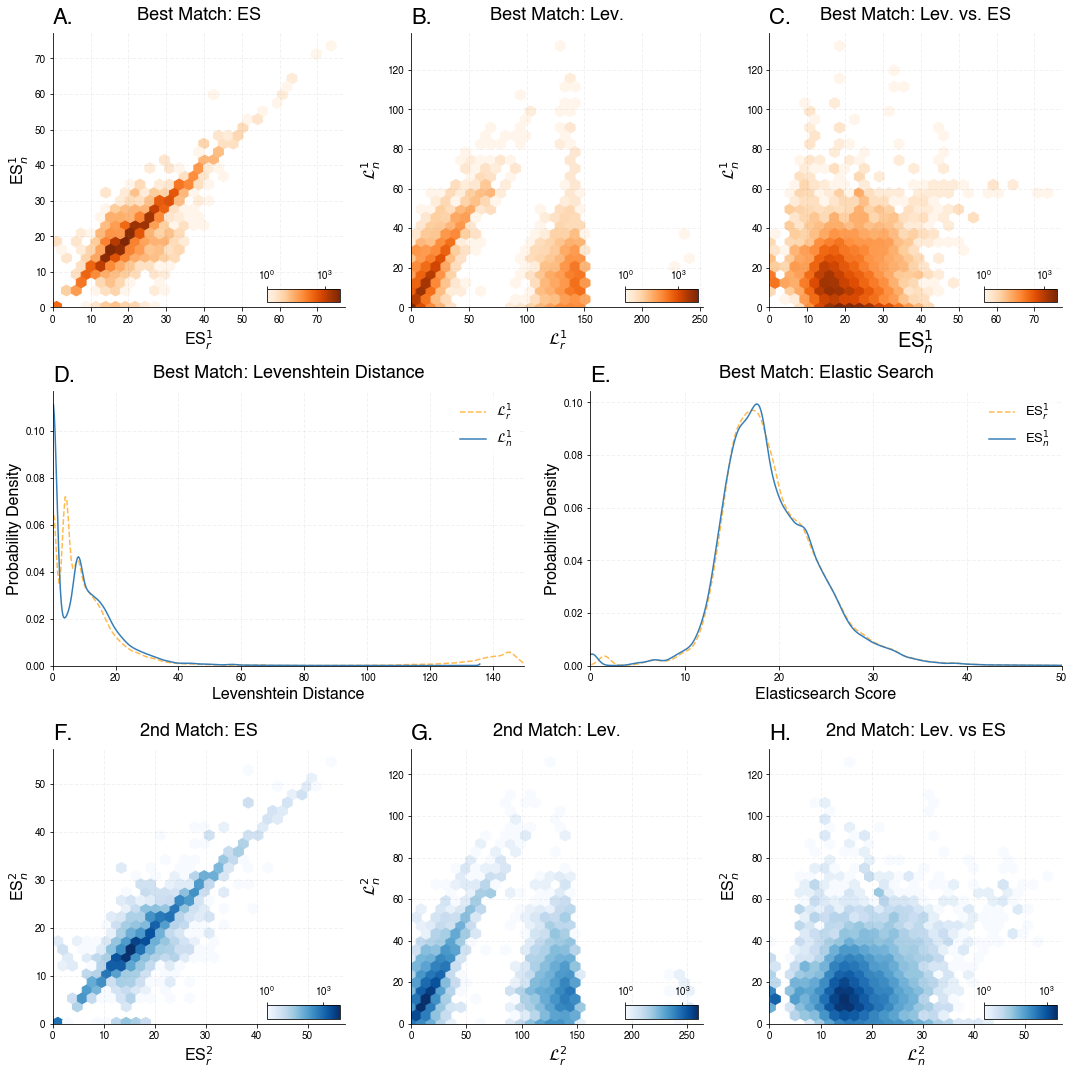

In [16]:
scoring_figures(sup_df, figure_path, (15, 15))
hide_toggle()

What are some of the most frequently unmatched entries?

In [17]:
concat = pd.concat([ccg_pay_df, trust_pay_df, nhsengland_pay_df])
concat = concat[concat['verif_match']=='No Match']
count_df = concat.groupby(['query_string_n'])['amount'].count().sort_values(ascending=False)
count_df[0:5]

query_string_n
INLAND REVENUE CIS                      2291
NATIONAL OFFENDER MANAGEMENT SERVICE    1956
MINISTRY OF JUSTICE                     1677
IMPERIAL COLLEGE                        1592
DONCASTER GP                            1567
Name: amount, dtype: int64

What are some of the highest value unmatched entries?

In [18]:
concat = pd.concat([ccg_pay_df, trust_pay_df, nhsengland_pay_df])
concat = concat[concat['verif_match']=='No Match']
count_df = concat.groupby(['query_string_n'])['amount'].sum().sort_values(ascending=False)
count_df[0:5]

query_string_n
INLAND REVENUE CIS                                     3.213644e+09
HULL AND EAST YORKSHIRE HOSPITALS NHS TRUST            2.640191e+09
COLCHESTER HOSPITAL UNIVERSITY NHS FOUNDATION TRUST    1.304613e+09
TAMESIDE HOSPITAL NHS FOUNDATION TRUST                 9.003347e+08
WEST LONDON MENTAL HEALTH NHS TRUST                    8.567310e+08
Name: amount, dtype: float64

What are some of the biggest company only recipients by number of payments?

In [19]:
concat = pd.concat([ccg_pay_df, trust_pay_df, nhsengland_pay_df])
concat = concat[concat['match_type']=='Companies House']
count_df = concat.groupby(['verif_match'])['amount'].count().sort_values(ascending=False)
count_df[0:5]

verif_match
NHS PROFESSIONALS LIMITED              22857
NHS PROPERTY SERVICES LIMITED          17903
ROCHE PRODUCTS LIMITED                 13695
HEALTHCARE AT HOME LIMITED             12835
NOVARTIS PHARMACEUTICALS UK LIMITED    11077
Name: amount, dtype: int64

What are some of the biggest company only recipients by value?

In [20]:
concat = pd.concat([ccg_pay_df, trust_pay_df, nhsengland_pay_df])
concat = concat[concat['match_type']=='Companies House']
count_df = concat.groupby(['verif_match'])['amount'].sum().sort_values(ascending=False)
count_df[0:5]

verif_match
NHS PROFESSIONALS LIMITED                                         2.984508e+09
NHS PROPERTY SERVICES LIMITED                                     1.341824e+09
THE COVENTRY AND RUGBY HOSPITAL COMPANY PUBLIC LIMITED COMPANY    9.370274e+08
CARE UK CLINICAL SERVICES LIMITED                                 9.019509e+08
PARTNERSHIPS IN CARE LIMITED                                      8.106066e+08
Name: amount, dtype: float64

## 4 Visualise the institutional distribution

Where does the money go? Lets plot an 'infographic' style thing with various measures

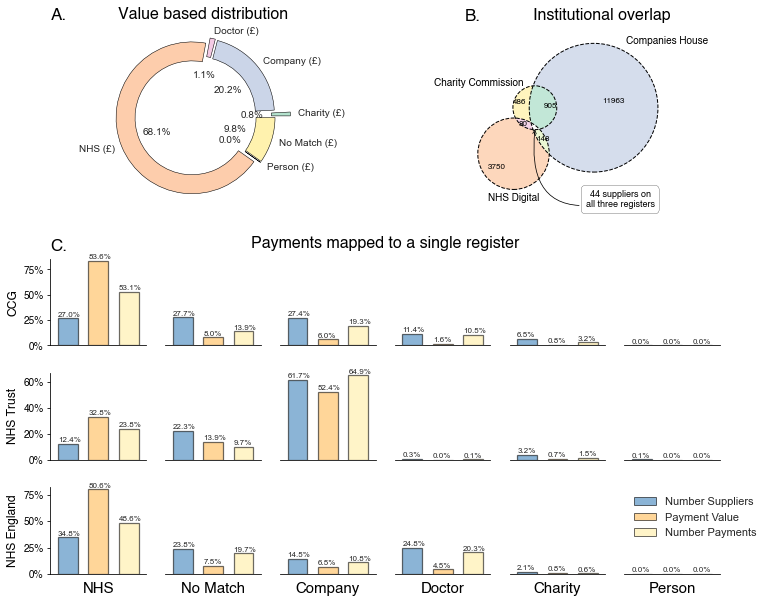

In [21]:
plot_match_distribution(sup_df, trust_pay_df, ccg_pay_df,
                        nhsengland_pay_df, figure_path, (12, 10))
hide_toggle()

The above figure shows only payments which are exclusively mapped to one register. What about including overlaps?

In [22]:
overlapping_summary(trust_pay_df, ccg_pay_df, nhsengland_pay_df)

Percent value INCLUDING overlapping payments to CH in NHS Trust data: 54.16
Percent value INCLUDING overlapping payments to CH in CCG data: 6.05
Percent value INCLUDING overlapping payments to CH in NHS England data: 6.59


Percent value INCLUDING overlapping payments to CC in NHS Trust data: 0.77
Percent value INCLUDING overlapping payments to CC in CCG data: 0.85
Percent value INCLUDING overlapping payments to CC in NHS England data: 0.84


In [10]:
concat = pd.concat([trust_pay_df, ccg_pay_df, nhsengland_pay_df], ignore_index=True)
concat = concat[concat['match_type'].str.contains('Companies House: Charity Commission: NHS Digital')]
concat.groupby(['supplier'])['amount'].sum().sort_values(ascending=False)

supplier
ST LUKES HOSPICE                                               34560154.0
CHILDRENS TRUST (THE)                                          32938532.0
FARLEIGH HOSPICE                                               14289842.0
TURNING POINT                                                  12762790.0
EARL MOUNTBATTEN HOSPICE                                       12628346.0
PILGRIMS HOSPICES IN EAST KENT                                 12421423.0
ST GEMMAS HOSPICE                                              11936118.0
DOUGLAS MACMILLAN HOSPICE                                      10714277.0
THE MATTHEW PROJECT                                             9704829.0
ST GILES HOSPICE                                                8168368.0
KIRKWOOD HOSPICE                                                7658910.0
CHILDRENS HOSPICE SOUTH WEST                                    7371877.0
NORTH LONDON HOSPICE                                            6141997.0
HOSPICE IN THE WEALD         

## 5. Summarsize charitable payments and suppliers

Lets now get to the crux of the matter for the main non-profit analysis paper: where does the money actually go within the non-profit sector?

### 5.0 Build charity dataframe

Lets build some charity specific dataframes: these are for downstream analysis and only contain information on payments going to charities from trusts, ccgs, nhs england, and then the three combined.

In [23]:
pay_df_cc_ccg, cc_sup_ccg = build_charity_df(ccg_pay_df,
                                             cc_name, icnpo_df, cc_fin, data_path)
hide_toggle()

We are missing 47 registration numbers
Can't do anything about that...
This seems to be where two charities have the same normalised name, and neither has been  removed from the register
This leaves us with 932 charities with regnos.
We are missing 129 incomes
Can't do anything about that...
We are missing 0 ICNPO numbers which have charity numbers


In [24]:
pay_df_cc_nhsengland, cc_sup_nhsengland = build_charity_df(nhsengland_pay_df,
                                                           cc_name, icnpo_df, cc_fin, data_path)
hide_toggle()

We are missing 12 registration numbers
Can't do anything about that...
This seems to be where two charities have the same normalised name, and neither has been  removed from the register
This leaves us with 236 charities with regnos.
We are missing 34 incomes
Can't do anything about that...
We are missing 0 ICNPO numbers which have charity numbers


In [25]:
pay_df_cc_trust, cc_sup_trust = build_charity_df(trust_pay_df,
                                                 cc_name, icnpo_df, cc_fin, data_path)
hide_toggle()

We are missing 39 registration numbers
Can't do anything about that...
This seems to be where two charities have the same normalised name, and neither has been  removed from the register
This leaves us with 586 charities with regnos.
We are missing 96 incomes
Can't do anything about that...
We are missing 0 ICNPO numbers which have charity numbers


In [26]:
pay_df_cc, cc_sup = build_charity_df(pd.concat([trust_pay_df, ccg_pay_df, nhsengland_pay_df],
                                         ignore_index=True),
                                         cc_name, icnpo_df, cc_fin, data_path)
hide_toggle()

We are missing 76 registration numbers
Can't do anything about that...
This seems to be where two charities have the same normalised name, and neither has been  removed from the register
This leaves us with 1466 charities with regnos.
We are missing 220 incomes
Can't do anything about that...
We are missing 0 ICNPO numbers which have charity numbers


### 5.1 Charity summary

Lets now see what our _charitable_ datasets look like, filtering only on payments which have gone to charitable institutions (which do possibly overlap onto other institutions, but _not_ to other NHS Trusts or CCGs themselves). First for CCGs:

In [27]:
summarize_payments(pay_df_cc_ccg, 'charitable')
hide_toggle()

Describing cleaned charitable payments dataset!
Length of dataset: 21748
Total unique raw suppliers: 1078
Total unique verified suppliers: 979
Total value (£) of dataset: 1744925242
Smallest value payment: -2705794
Biggest value payment: 3532145
Average value payment: 80233
Earliest payment was: 2012-09-28 00:00:00
Latest payment was: 2020-02-29 00:00:00
Most payments is:  NHS_LEE_CCG (1226)
Highest value payments is: NHS_LEE_CCG (£144862082)
Most payments (other than "no match"): NUFFIELD HEALTH (2241)
Highest value of payments (other than "no match") is: NUFFIELD HEALTH (268797189.0)
Number of organisations in clean dataset is: 167
Number of files in clean dataset is: 5796


and then NHS England:

In [28]:
summarize_payments(pay_df_cc_nhsengland, 'charitable')
hide_toggle()

Describing cleaned charitable payments dataset!
Length of dataset: 3766
Total unique raw suppliers: 255
Total unique verified suppliers: 248
Total value (£) of dataset: 1293924130
Smallest value payment: -1049190
Biggest value payment: 9335024
Average value payment: 343580
Earliest payment was: 2013-04-24 00:00:00
Latest payment was: 2019-09-30 00:00:00
Most payments is:  NHS_England (3766)
Highest value payments is: NHS_England (£1293924130)
Most payments (other than "no match"): ST ANDREWS HEALTHCARE (358)
Highest value of payments (other than "no match") is: ST ANDREWS HEALTHCARE (718834054.0)
Number of organisations in clean dataset is: 1
Number of files in clean dataset is: 68


Then for Trusts:

In [29]:
summarize_payments(pay_df_cc_trust, 'charitable')
hide_toggle()

Describing cleaned charitable payments dataset!
Length of dataset: 10234
Total unique raw suppliers: 753
Total unique verified suppliers: 622
Total value (£) of dataset: 674248277
Smallest value payment: -1529636
Biggest value payment: 2350782
Average value payment: 65883
Earliest payment was: 2010-01-29 00:00:00
Latest payment was: 2020-03-31 00:00:00
Most payments is:  NHS_CUH_Trust (654)
Highest value payments is: NHS_CUH_Trust (£44689509)
Most payments (other than "no match"): ST JOHN AMBULANCE (837)
Highest value of payments (other than "no match") is: ST JOHN AMBULANCE (39427012.0)
Number of organisations in clean dataset is: 170
Number of files in clean dataset is: 3491


And then for both combined:

In [30]:
summarize_payments(pay_df_cc, 'charitable')
hide_toggle()

Describing cleaned charitable payments dataset!
Length of dataset: 35748
Total unique raw suppliers: 1807
Total unique verified suppliers: 1539
Total value (£) of dataset: 3713097649
Smallest value payment: -2705794
Biggest value payment: 9335024
Average value payment: 103868
Earliest payment was: 2010-01-29 00:00:00
Latest payment was: 2020-03-31 00:00:00
Most payments is:  NHS_England (3766)
Highest value payments is: NHS_England (£1293924130)
Most payments (other than "no match"): NUFFIELD HEALTH (2748)
Highest value of payments (other than "no match") is: ST ANDREWS HEALTHCARE (730926246.0)
Number of organisations in clean dataset is: 338
Number of files in clean dataset is: 9324


### 5.2 Tabulate the charities (groupby)

Stack these first two tables together vertically in the paper. They show which non-profits are getting most money. The nameno which maps to the National Blood Authority is curious. First for CCGs:

In [31]:
tabulate_charities(pay_df_cc_ccg, cc_name, icnpo_df, cc_fin,
                   table_path, 'ccg_payments_to_charities.csv')
hide_toggle()

                       verif_match     amount  count    regno     regdate  ICNPO        income  CC Rank
                   NUFFIELD HEALTH  268797189   2241   205533  1962-09-22   3100  4.835600e+09        6
        MARIE STOPES INTERNATIONAL   41711869   1086   265543  1973-05-09   3400  1.603164e+09       58
                              BPAS   38626896    795   289145  1984-04-25   3400  2.078000e+08     1366
                       MARIE CURIE   52378303    550   207994  1962-09-22   3400  1.091030e+09      243
                ALZHEIMERS SOCIETY   21500537    502   296645  1987-04-23   3400  6.660080e+08      423
               ST BARNABAS HOSPICE   46969409    470  1053814  1996-03-15   3200  7.631532e+07     4444
             ST ANDREWS HEALTHCARE   11492938    446  1104951  2004-07-16   3300  1.369600e+09      192
                   METHODIST HOMES   13655293    359  1083995  2000-12-04   6200  1.429769e+09      178
 ALTERNATIVE FUTURES GROUP LIMITED   26586982    351  1008587  1

and then for NHS England:

In [32]:
tabulate_charities(pay_df_cc_nhsengland, cc_name, icnpo_df, cc_fin,
                   table_path, 'nhsengland_payments_to_charities.csv')
hide_toggle()

                                verif_match     amount  count    regno     regdate  ICNPO        income  CC Rank
                      ST ANDREWS HEALTHCARE  718834054    358  1104951  2004-07-16   3300  1.369600e+09      192
                                       RAPT   27975899    264  1163276  2015-08-24   3100           NaN   290847
 HEALTHCARE QUALITY IMPROVEMENT PARTNERSHIP  109023655    168  1127049  2008-12-04   3400  1.499686e+08     2213
                            PHOENIX FUTURES   15269975    144   284880  1982-07-19   6200  1.642872e+08     1924
                            NUFFIELD HEALTH   15915996    139   205533  1962-09-22   3100  4.835600e+09        6
         ROYAL HOSPITAL FOR NEURODISABILITY   56540223    116   205907  1963-12-02   3100  2.191100e+08     1317
                          THE FORWARD TRUST   16834145    114  1001701  1991-01-29   7200  1.371682e+08     2582
                        THE CHILDRENS TRUST   30341355    100   288018  1983-10-18   4100  1.734

Then for trusts:

In [33]:
tabulate_charities(pay_df_cc_trust, cc_name, icnpo_df, cc_fin,
                   table_path, 'trust_payments_to_charities.csv')
hide_toggle()

                         verif_match    amount  count    regno     regdate  ICNPO        income  CC Rank
                   ST JOHN AMBULANCE  39427012    837  1077265  1999-09-02   3400  6.001000e+08      456
                       ANTHONY NOLAN  15953040    475   803716  1990-07-12   3400  2.935340e+08     1047
 THE ANTHONY NOLAN BONE MARROW TRUST  13675744    391   803716  1990-07-12   3400  2.935340e+08     1048
                     NUFFIELD HEALTH  20483361    368   205533  1962-09-22   3100  4.835600e+09        6
                  NUFFIELD HOSPITALS  17301033    238   205533  1962-09-22   3100  4.835600e+09        5
                       PHOENIX HOUSE  18243932    223   284880  1982-07-19   6200  1.642872e+08     1925
            NATIONAL BLOOD AUTHORITY  20438164    223  1061771  1997-04-10   3100  5.701230e+05    65465
                          THE PRIORY  20927380    189   273022  1979-08-15   6100  5.582131e+06    19737
                     PHOENIX FUTURES   8221068    176  

And then for all three:

In [34]:
tabulate_charities(pay_df_cc, cc_name, icnpo_df, cc_fin,
                   table_path, 'both_payments_to_charities.csv')
hide_toggle()

                verif_match     amount  count    regno     regdate  ICNPO        income  CC Rank
            NUFFIELD HEALTH  305196546   2748   205533  1962-09-22   3100  4.835600e+09        6
 MARIE STOPES INTERNATIONAL   43334457   1117   265543  1973-05-09   3400  1.603164e+09       58
          ST JOHN AMBULANCE   39927011    844  1077265  1999-09-02   3400  6.001000e+08      456
      ST ANDREWS HEALTHCARE  730926246    834  1104951  2004-07-16   3300  1.369600e+09      192
                       BPAS   38626896    795   289145  1984-04-25   3400  2.078000e+08     1366
                MARIE CURIE   54661509    595   207994  1962-09-22   3400  1.091030e+09      243
         ALZHEIMERS SOCIETY   25939290    577   296645  1987-04-23   3400  6.660080e+08      423
        ST BARNABAS HOSPICE   49395756    490  1053814  1996-03-15   3200  7.631532e+07     4444
              ANTHONY NOLAN   15953040    475   803716  1990-07-12   3400  2.935340e+08     1047
            METHODIST HOMES   

### 5.3 ICNPO and Class Distributions

#### 5.3.1. Lets first look at how this grouping looks over all ICNPO groups

In [35]:
icnpo_groupings(pay_df_cc, pay_df_cc_ccg, pay_df_cc_trust, pay_df_cc_nhsengland, 
                cc_name, icnpo_df, icnpo_lookup, table_path)
hide_toggle()

                             icnpo_group  count_ccg  amount_ccg  count_trust  amount_trust  count_eng  amount_eng
icnpo                                                                                                            
1100                   Culture and sport       1.40        0.15         3.08          0.43       1.27        0.01
1200                   Culture and sport       1.40        0.14         0.85          0.29       0.85        0.11
1300                   Culture and sport       0.11        0.00         0.00          0.00       0.00        0.00
2100                           Education       0.32        0.01         1.37          0.48       0.85        0.01
2120                           Education       0.11        0.03         0.51          0.14       0.00        0.00
2130                           Education       0.11        0.01         0.51          0.83       0.00        0.00
2200                           Education       0.43        0.24         1.03          0.

#### 5.3.2 Lets do some basic NLP on the self described non-profit purposes

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tsl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tsl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


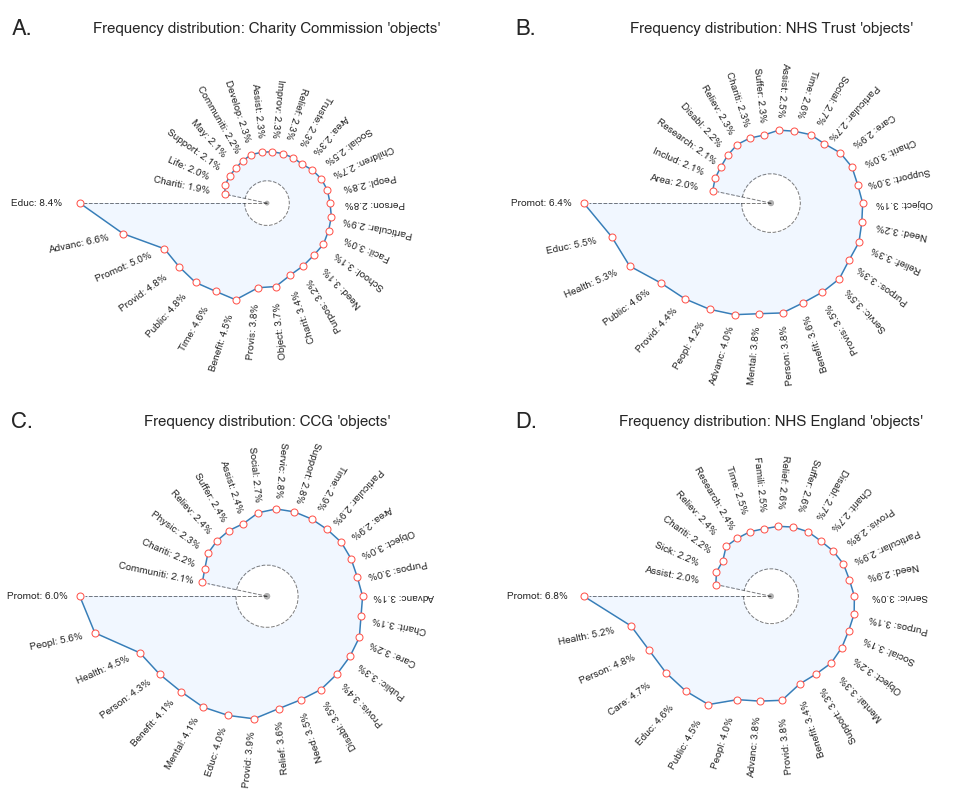

In [36]:
make_obj_freq(cc_objects, cc_name, ccg_pay_df, trust_pay_df,
              nhsengland_pay_df, figure_path)

#### 5.3.3. Then lets look at how this grouping looks over all CC Classes (non-unique)

In [37]:
class_groupings(pay_df_cc, pay_df_cc_ccg, pay_df_cc_trust,
                pay_df_cc_nhsengland, cc_name, cc_class,
                table_path)
hide_toggle()

                                            classtext  amo_ccg  cou_ccg  amo_tr  cou_tr  amo_eng  cou_eng
0                               Accommodation/housing     1.86     2.33    1.82    2.01     0.47     1.63
1                Acts As An Umbrella Or Resource Body     0.94     2.04    1.49    1.95     1.68     2.88
2                                       Amateur Sport     0.21     0.81    0.37    0.76     0.08     0.48
3                                             Animals     0.00     0.02    0.04    0.02      NaN      NaN
4           Armed Forces/emergency Service Efficiency     0.01     0.05    0.03    0.10     0.01     0.10
5                       Arts/culture/heritage/science     0.28     0.93    0.40    1.17     0.09     0.82
6                               Children/young People     6.06     5.46    6.31    5.63     9.60     6.43
7                                          Disability     4.73     5.47    2.81    3.66     1.69     4.17
8           Economic/community Development/emp

### 5.4 Geospatial Distribution

CCGs map into distinct CCG coverage polygons, so lets use the NHS shapefile data to see how different trusts (>50 payments) vary their spending to CC organisations, printing out the highest number of %s to VCS charities:

We have 191 trusts in our dataset
Of them, 165 procure < 2.5% from CCEW by value
Of them, 75 procure < 2.5% from CCEW by count

The top 5 Trusts by %to VCS are: 

             dept    amount_cc  amount_pc_cc  count_cc
143  nhs_stok_ccg   32333649.0      2.743001     287.0
173   nhs_nag_ccg    2735907.0      2.445316      21.0
68   nhs_here_ccg   33821412.0      2.378920     338.0
185   nhs_lee_ccg  144862082.0      2.374890    1226.0
65   nhs_hast_ccg    8633952.0      2.232466      77.0


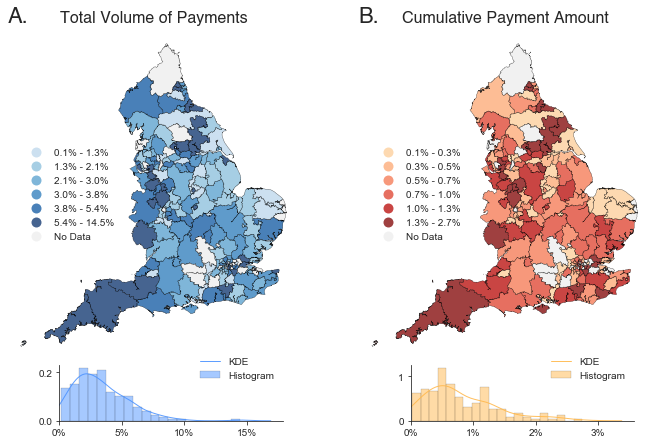

In [38]:
ccg_merged = make_ccg_to_gdf(ccg_pay_df,
                             pay_df_cc_ccg, support_path)
gdf=make_gdf(ccg_merged, shape_path, support_path)
plot_choropleths_ccg(gdf, figure_path)
hide_toggle()

Trusts dont map exactly to boundaries, so we geocode their exact address and plot the same metrics:

We have 169 trusts in our dataset
Of them, 140 procure < 2.5% from CCEW by value
Of them, 120 procure < 2.5% from CCEW by count

The top 5 Trusts by %to VCS are: 

              dept  charity_amount  pc_amount  charity_count
39   NHS_DHC_Trust      26028044.0  20.304301          312.0
10   NHS_BER_Trust       1174710.0   9.549714            6.0
85   NHS_LIP_Trust       6086158.0   8.872595           57.0
112  NHS_NOT_Trust      23766975.0   7.751418          324.0
84   NHS_LIN_Trust      17954619.0   7.558876          127.0


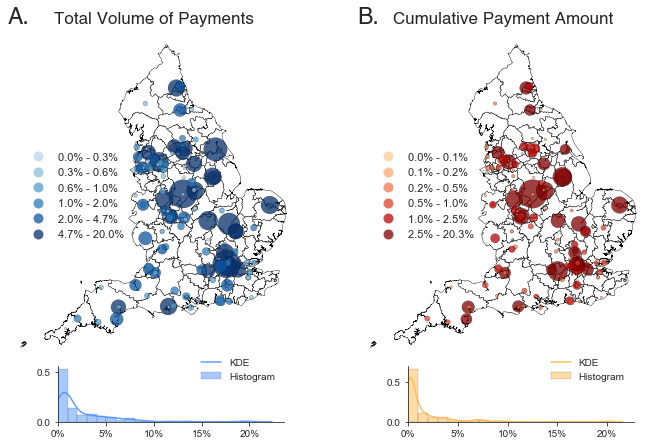

In [39]:
plot_choropleths_trusts(support_path, shape_path, figure_path,
                        trust_pay_df, pay_df_cc)
hide_toggle()

Just what is it that DHC is spending so much on from the CCEW?

In [40]:
dhc_cc = trust_pay_df[(trust_pay_df['match_type'].str.contains('Charity')) &
                      (trust_pay_df['dept'].str.contains('_DHC_'))]
dhc = trust_pay_df[trust_pay_df['dept'].str.contains('_DHC_')]
print('There are ' + str(len(dhc_cc)) + ' payments to CCEW organisations from DHC')
print('CCEW organisations supplying DHC: \n\n' + str(dhc_cc.groupby('verif_match')['amount'].sum().\
      sort_values(ascending=False)))
print('\nTop supplier gets: ' + str(dhc_cc.groupby('verif_match')['amount'].sum().\
                                    sort_values(ascending=False)[0]/dhc['amount'].sum()))

There are 312 payments to CCEW organisations from DHC
CCEW organisations supplying DHC: 

verif_match
PHOENIX HOUSE                           14879960.0
DERWENT RURAL COUNSELLING SERVICE        7331454.0
AQUARIUS ACTION PROJECTS                 2055421.0
DERBYSHIRE ALCOHOL ADVICE SERVICE        1444559.0
SPODA                                      80160.0
THE RICHMOND FELLOWSHIP                    80009.0
HEALTHWATCH DERBYSHIRE LIMITED             40000.0
TURNING POINT                              33786.0
CHEADLE ROYAL HOSPITAL                     30561.0
ST ANDREWS HEALTHCARE                      27047.0
RELATE DERBY AND SOUTHERN DERBYSHIRE       25087.0
Name: amount, dtype: float64

Top supplier gets: 0.11607755898971313


Lets also look at something more specific with regards to geographic variation:

In [41]:
something_with_nuts1(support_path, trust_pay_df, shape_path)

                                amount   count  count_ccew   amount_ccew  count_ccew_pc  amount_ccew_pc
nuts118nm                                                                                              
East Midlands (England)   7.193020e+09   58342        1226  9.554177e+07       2.101402        1.328257
East of England           7.222003e+09   60345        1381  9.065148e+07       2.288508        1.255212
London                    2.370574e+10  172905        2309  1.543832e+08       1.335415        0.651248
North East (England)      3.830850e+09   29720         367  1.965051e+07       1.234859        0.512954
North West (England)      1.522134e+10   97554        1259  7.242870e+07       1.290567        0.475837
South East (England)      7.820002e+09   62567         686  3.846370e+07       1.096425        0.491863
South West (England)      7.075981e+09   66489        1201  6.971228e+07       1.806314        0.985196
West Midlands (England)   8.133985e+09   65716        1135  9.76

### 5.5 Charity Age Distribution

How do charities which recieve payments from the NHS differ in terms of their age in terms to those who don't?

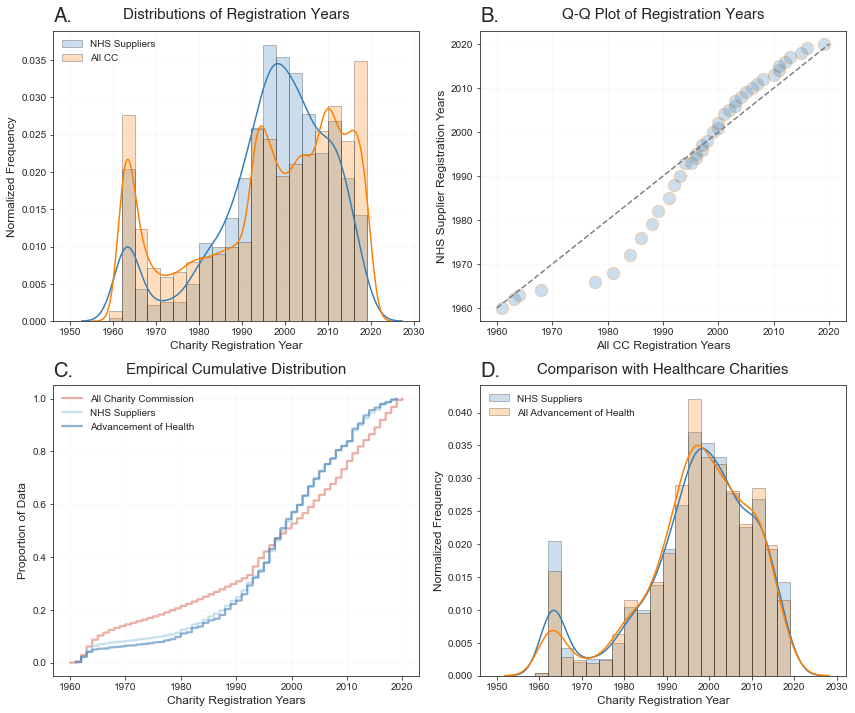

In [42]:
charity_age(pd.concat([trust_pay_df, ccg_pay_df, nhsengland_pay_df],
                      ignore_index=True),
            cc_sup, cc_name, cc_class, figure_path)

In [43]:
now = pd.to_datetime('now')
cc_sup['age'] = (now - cc_sup['regdate']).dt.total_seconds() / (60*60*24*365.25)
cc_name['age'] = (now - cc_name['regdate']).dt.total_seconds() / (60*60*24*365.25)
print('Average age of NHS suppliers: ' + str(cc_sup['age'].mean()))
print('Average age of all CCEW: ' + str(cc_name['age'].mean()))

Average age of NHS suppliers: 23.91705029272666
Average age of all CCEW: 26.67500981571385


Do older, more established charities get _more_ income from NHS orgs?

In [44]:
more_or_less_by_age(cc_sup)

Full sample:

Correlation between age and amount:  0.045916970281872506
Correlation between age and count: 0.140018116071332
Correlation between age and amount by rank:  0.21207143778875848
Correlation between age and count by rank: 0.2049897021751914
-------------------------------------------
Companies registered before 2012:

Correlation between age and amount:  0.040737304796670766
Correlation between age and count: 0.13275861641718087
Correlation betwen age and amount, by rank:  0.19095219042976797
Correlation between age and count, by rank:  0.17993576672488162


The percent of charities without an address:  0.45474137344591414
The percent of unique regnos in our database:  327547
We have 205920 regnos in the ccew...
But only 167810 regnos with income data!
We have 249  regnos of NHS England data in total.
We have 3078 rows of NHS England data with post-2012 income data
We have 198 rows of NHS England data with pre-2012 income data
We have 927  regnos of CCG data in total.
We have 11592 rows of CCG data with post-2012 income data
We have 752 rows of CCG data with pre-2012 income data
We have 578  regnos of trust data in total.
We have 6873 rows of trust data with post-2012 income data
We have 450 rows of trust data with pre-2012 income data


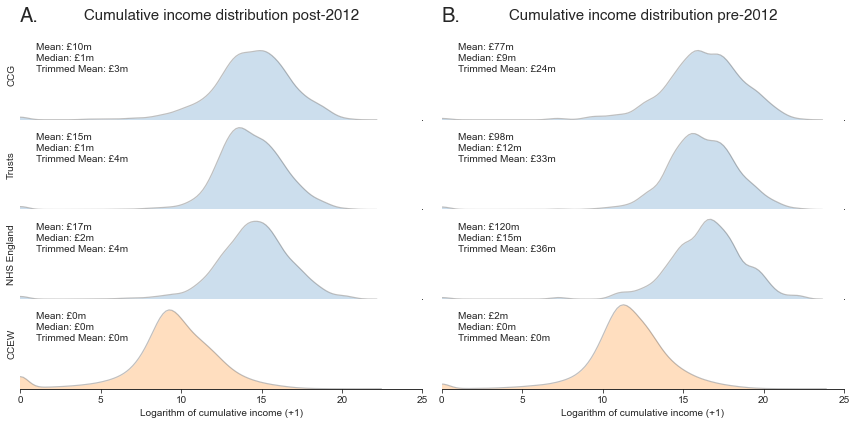

In [45]:
make_income_dists(nhsengland_pay_df, trust_pay_df, ccg_pay_df, cc_path, norm_path, figure_path)

Lets also look at payments decomposed into the NCVO definition of charity income boundaries:

In [46]:
make_inc_table(cc_path, norm_path, nhsengland_pay_df,
               trust_pay_df, ccg_pay_df, '2018',
               os.path.join(table_path, 'income_table_2018.csv'))

The percent of charities without an address:  0.45474137344591414
The percent of unique regnos in our database:  327547
                      Minor    Small   Medium    Large    Major SuperMajor
Entire CCEW          37.465  37.5578  19.8449   4.3213   0.7519     0.0591
Organisation Count   2.6455   4.5855  32.8042  40.8289  16.9312     2.2046
Percent of Payments    2.56     9.14    16.51    26.71    26.03      19.05
Percent of Amount      3.25    11.68    25.49    37.14      9.5      12.95


In [47]:
make_inc_table(cc_path, norm_path, nhsengland_pay_df,
               trust_pay_df, ccg_pay_df, '2011',
               os.path.join(table_path, 'income_table_2011.csv'))

The percent of charities without an address:  0.45474137344591414
The percent of unique regnos in our database:  327547
                       Minor    Small   Medium   Large    Major SuperMajor
Entire CCEW          42.3882  36.7024  16.3094  3.8602   0.6934     0.0464
Organisation Count    2.1563   6.0198  35.9389  38.814  14.9146     2.1563
Percent of Payments     2.77     3.47    23.61   28.57    26.03      15.55
Percent of Amount       2.82     3.78     34.2   38.54     8.69      11.98


### 5.6 Over TIme

How has this changed over time? First break it down by ICNPO, then aggregate up

In [48]:
ts_trust_month, ts_icnpo_plot_trust = make_temporal_df(trust_pay_df,
                                                       pay_df_cc_trust,
                                                       icnpo_df, cc_name)
ts_ccg_month, ts_icnpo_plot_ccg = make_temporal_df(ccg_pay_df,
                                                   pay_df_cc_ccg,
                                                   icnpo_df, cc_name)
ts_nhsengland_month, ts_icnpo_plot_nhsengland = make_temporal_df(nhsengland_pay_df,
                                                                 pay_df_cc_nhsengland,
                                                                 icnpo_df, cc_name)

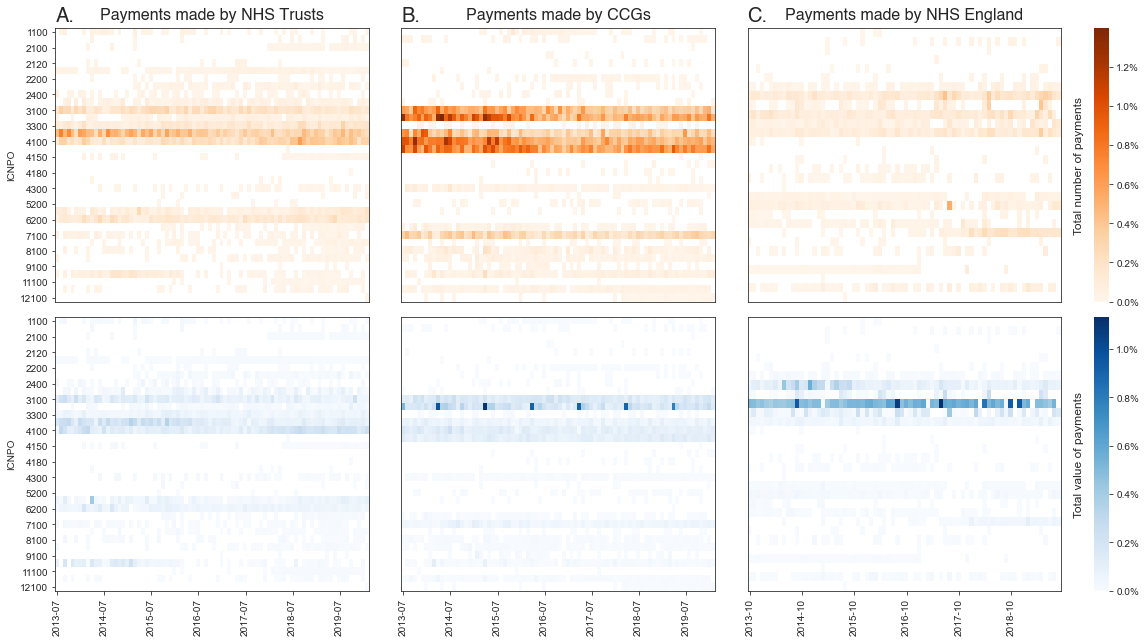

In [49]:
plot_heatmaps(ts_icnpo_plot_trust, ts_icnpo_plot_ccg, ts_icnpo_plot_nhsengland, figure_path)

Lets have a quick look at that cyclical pattern in the middle lower panel above!

The average percent of payments going to ICNPO 3200 in April:  0.931
The average percent of payments going to ICNPO 3200 in all other months:  0.201


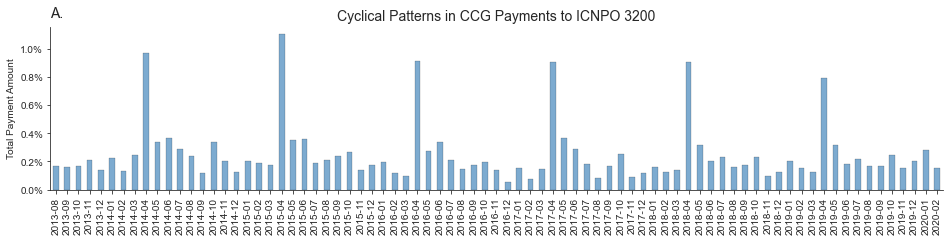

In [50]:
cyclical_3200(ts_icnpo_plot_ccg)

Lets now make the monthly and annual data:

In [51]:
ts_ccg_annual = make_annual(ccg_pay_df, pay_df_cc_ccg, cc_name)
ts_trust_annual = make_annual(trust_pay_df, pay_df_cc_trust, cc_name)
ts_ccg_monthly = make_monthly(ccg_pay_df, pay_df_cc_ccg, cc_name)
ts_trust_monthly = make_monthly(trust_pay_df, pay_df_cc_trust, cc_name)
ts_nhsengland_monthly = make_monthly(nhsengland_pay_df, pay_df_cc_nhsengland, cc_name)
ts_nhsengland_annual = make_annual(nhsengland_pay_df, pay_df_cc_nhsengland, cc_name)

Make a table from the monthly figures to check out cyclicality in general:

In [52]:
plot_temporal_makemonths(ts_ccg_monthly, ts_trust_monthly, ts_nhsengland_monthly)

       Count_CCG  Amount_CCG  Count_Trust  Amount_Trust  Count_NHSEngland  Amount_NHSEngland
Month                                                                                       
01      3.658711    0.837471     1.489094      0.733510          0.562735           0.789721
02      3.219877    0.709294     1.575945      0.825954          0.553977           0.843692
03      2.718997    0.729792     1.517202      0.839833          0.666597           0.539165
04      3.655637    1.541527     1.490173      0.851201          0.610726           0.794983
05      3.839739    0.971946     1.451219      0.750164          0.668627           0.856610
06      3.280917    0.884377     1.532538      0.721689          0.541443           0.936209
07      3.894421    0.885469     1.494387      0.661527          0.711780           0.865315
08      3.227139    0.709946     1.593748      0.788483          0.721950           1.088416
09      3.116500    0.709288     1.649595      0.808922          0.718

Make some rolling datasets of various windows to plot in the main time series figure for the paper:

In [53]:
rolling_df_45 = make_rolling_windows(ccg_pay_df, trust_pay_df, nhsengland_pay_df, 90)
rolling_df_365 = make_rolling_windows(ccg_pay_df, trust_pay_df, nhsengland_pay_df, 365)

And finally, plot the main time series type of figure for the paper:

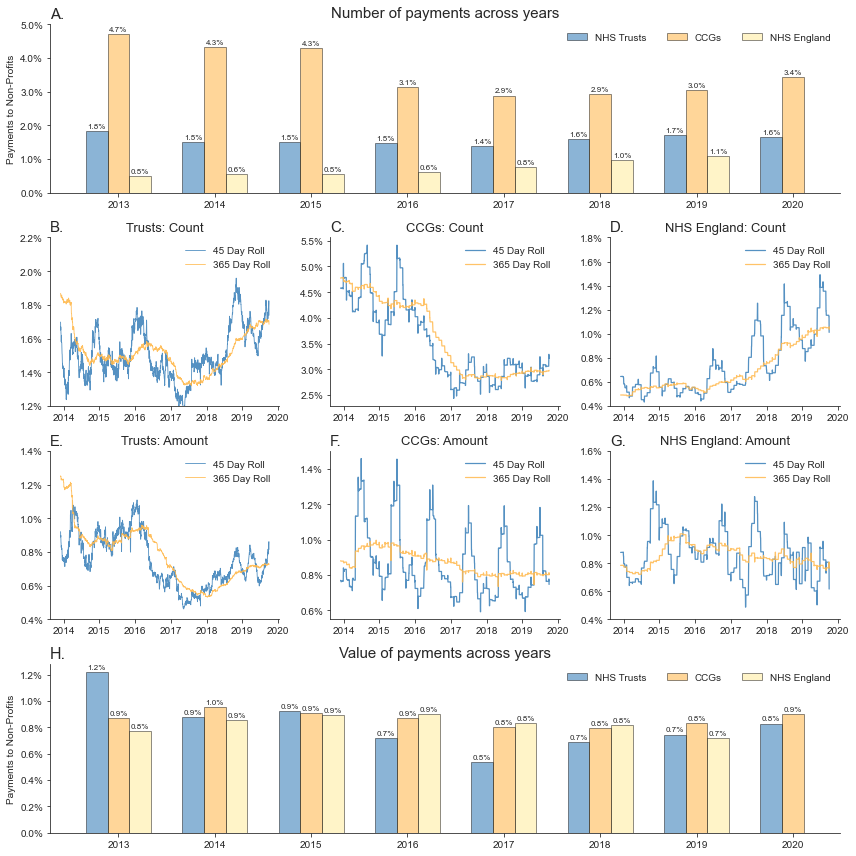

In [54]:
plot_temporal(ts_ccg_annual, ts_trust_annual, ts_nhsengland_annual,
              rolling_df_45, rolling_df_365, figure_path)

In [55]:
rolling_df_45_top10 = make_rolling_windows_top10(ccg_pay_df,
                                                 trust_pay_df,
                                                 nhsengland_pay_df,
                                                 pd.concat([nhsengland_pay_df, trust_pay_df, ccg_pay_df],
                                                 ignore_index=True),
                                                 45)

rolling_df_90_top10 = make_rolling_windows_top10(ccg_pay_df,
                                                 trust_pay_df,
                                                 nhsengland_pay_df,
                                                 pd.concat([nhsengland_pay_df, trust_pay_df, ccg_pay_df],
                                                 ignore_index=True),
                                                 90)
rolling_df_180_top10 = make_rolling_windows_top10(ccg_pay_df,
                                                  trust_pay_df,
                                                  nhsengland_pay_df,
                                                  pd.concat([nhsengland_pay_df, trust_pay_df, ccg_pay_df],
                                                  ignore_index=True),
                                                  180)
rolling_df_365_top10 = make_rolling_windows_top10(ccg_pay_df,
                                                  trust_pay_df,
                                                  nhsengland_pay_df,
                                                  pd.concat([nhsengland_pay_df, trust_pay_df, ccg_pay_df],
                                                  ignore_index=True),
                                                  365)

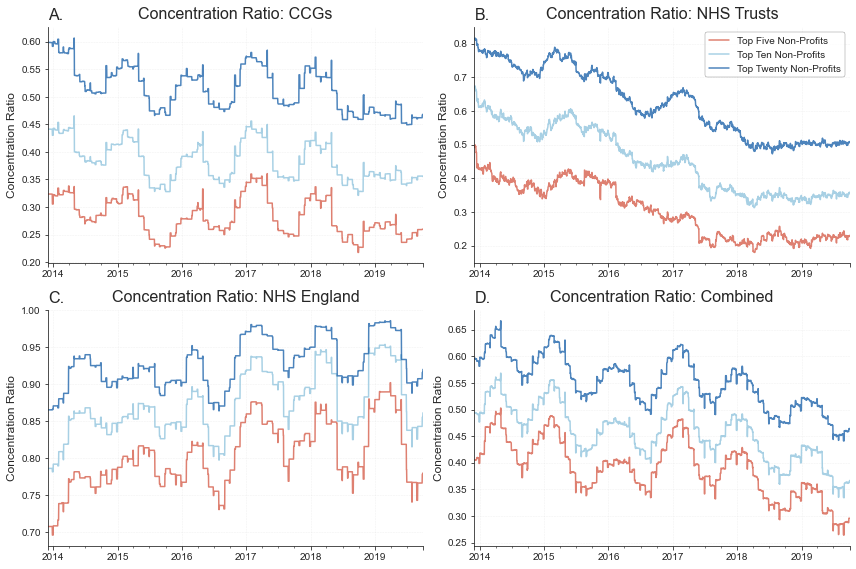

In [56]:
plot_conc(figure_path, rolling_df_45_top10, rolling_df_90_top10, rolling_df_180_top10, rolling_df_365_top10)

In [57]:
rolling_df_180_top10.loc['2013-12-01',:]

CCG_Amount_5            0.323618
Trust_Amount_5           0.49172
NHSEngland_Amount_5     0.707272
Combined_Amount_5        0.40539
CCG_Amount_10           0.441369
Trust_Amount_10         0.669029
NHSEngland_Amount_10    0.785849
Combined_Amount_10      0.493678
CCG_Amount_20           0.598784
Trust_Amount_20         0.814436
NHSEngland_Amount_20    0.865029
Combined_Amount_20      0.595294
Name: 2013-12-01 00:00:00, dtype: object

In [58]:
rolling_df_180_top10.loc['2019-10-01', :]

CCG_Amount_5            0.260019
Trust_Amount_5          0.227236
NHSEngland_Amount_5     0.779729
Combined_Amount_5       0.296014
CCG_Amount_10           0.355209
Trust_Amount_10          0.35853
NHSEngland_Amount_10    0.861042
Combined_Amount_10      0.366887
CCG_Amount_20           0.468519
Trust_Amount_20          0.50926
NHSEngland_Amount_20    0.919766
Combined_Amount_20      0.463932
Name: 2019-10-01 00:00:00, dtype: object